In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L1 = (np.sum(np.abs(zr-np.real(ztot)))/n) +\
         (np.sum(np.abs(zj-np.abs(np.imag(ztot))))/n)
    return L1


def otto_model_L2(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = np.concatenate((zr - np.real(ztot), zj-np.abs(np.imag(ztot))))
    L2 = np.dot(e.T, e)/n
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary 

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    return L2


def plot_results(x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_lk)

    plt.figure()
    plt.title(title)
    plt.plot(zr, zj, '.-', label='Test Data')
    plt.plot(zr_l1, zj_l1, 'o', label='L1 norm')
    plt.plot(zr_l2, zj_l2, 's', label='L2 norm')
    plt.plot(zr_linf, zj_linf, '>', label=r'L$\infty$ norm')
    plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    # real residuals
    # er = zr - zr_x
    # imaginary residuals
    # ej = zj - zj_x
    
    # plt.figure()
    # plt.title(title)
    # plt.semilogx(f, er, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Real residuals')
    # plt.grid()
    
    # plt.figure()
    # ptl.title(title)
    # plt.semilogx(f, ej, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Imaginary residuals')
    # plt.grid()
    # plt.show()


def opt_routine(obj_function, runs=10):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    for i in range(runs):
        # run differential evolution
        solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
                                 limits=bounds, minimize=True)
        solver.cr, solver.f = 1.0, 0.9
        best, fit = solver.run(n_it=1000)
        fit = fit*-1
        # polish with L BFGS
        res_bfgs = fmin_l_bfgs_b(obj_function, best, fprime=None, args=(),
                                 approx_grad=True, bounds=bounds, m=10,
                                 factr=10000000.0, pgtol=1e-05, epsilon=1e-04,
                                 iprint=-1, maxfun=15000, maxiter=15000,
                                 disp=None, callback=None, maxls=20)
        # if polish better save polish results
        # print(fit, res_bfgs[1])
        if res_bfgs[1] < fit:
            opts[i] = res_bfgs[1]
            results_x[i] = res_bfgs[0]
            # print('Polish was better')
        else:
            opts[i] = fit
            results_x[i] = best
            # print('Polish did not help')
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.argmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
    print('Objective value:', best_opt)
    print('Paramters:', best_x, '\n')
    return results_x, opts, best_x, best_opt

Optimization runtime 67.6559 seconds
Objective value: 8266.684903373172
Paramters: [3.95510510e-01 6.39706181e-01 1.71937863e+00 1.00000000e-04
 1.00000000e-02] 

Optimization runtime 62.4034 seconds
Objective value: 19031.447746673643
Paramters: [4.68906307e-01 5.03688007e-01 1.87811518e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 65.3753 seconds
Objective value: 634454.3801960585
Paramters: [4.98484285e+00 1.00000000e-04 2.44818011e+02 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 68.4752 seconds
Objective value: 1351143760.4302235
Paramters: [4.69357388e-01 4.99197969e-01 1.30853526e+01 1.00000000e+03
 1.00000000e-02] 



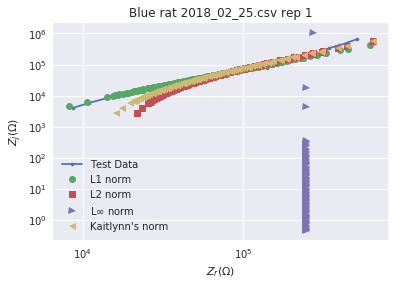

Optimization runtime 68.1255 seconds
Objective value: 26063.686586879354
Paramters: [4.33319966e-01 4.67363704e-01 4.42802439e+00 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 62.5345 seconds
Objective value: 31938.99407869421
Paramters: [4.16265445e-01 5.43346115e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 66.4367 seconds
Objective value: 143017.47385929036
Paramters: [5.00000085e-01 5.08124388e-01 1.00000000e-04 1.00000000e-04
 9.99999999e+02] 

Optimization runtime 68.8202 seconds
Objective value: 5292475756.853042
Paramters: [4.01541107e-01 5.89271158e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 



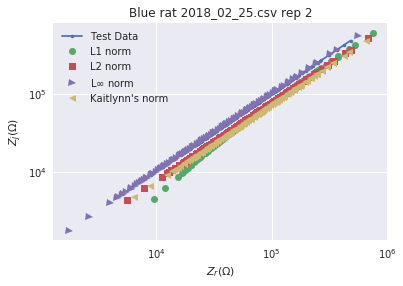

Optimization runtime 78.7340 seconds
Objective value: 42286.087674244925
Paramters: [4.44676167e-01 5.11741972e-01 1.86301112e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 73.2293 seconds
Objective value: 159555.36598667232
Paramters: [4.46303059e+00 1.00000000e-04 9.58880137e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 76.8842 seconds
Objective value: 1077101.602692577
Paramters: [4.45301983e+00 1.00000000e-04 3.74945166e+02 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 80.9641 seconds
Objective value: 4210015997747.86
Paramters: [4.41299372e+00 1.00000000e-04 7.50832057e+01 1.00000000e+03
 1.00000000e-02] 



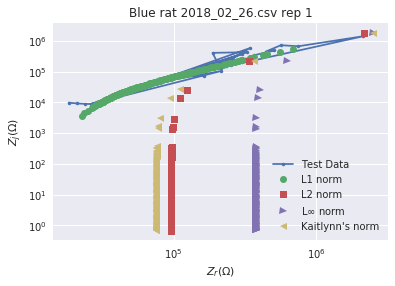

Optimization runtime 79.8436 seconds
Objective value: 152736.50066582195
Paramters: [4.45977735e+00 1.00000000e-04 6.36135025e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 73.1710 seconds
Objective value: 166508.6882453174
Paramters: [4.46141901e+00 1.00000000e-04 9.58293581e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 76.7842 seconds
Objective value: 1091070.6179759
Paramters: [4.45301983e+00 1.00000000e-04 3.74945166e+02 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 80.3511 seconds
Objective value: 4577489134554.14
Paramters: [4.40604444e+00 1.00000000e-04 7.86190604e+01 1.00000000e+03
 1.00000000e-02] 



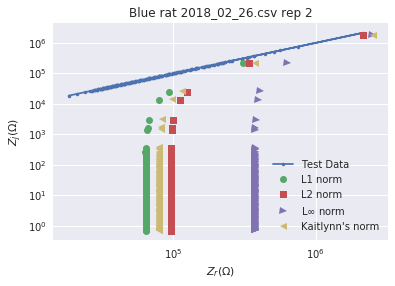

Optimization runtime 78.6247 seconds
Objective value: 726308.5364981431
Paramters: [5.20587532e-01 2.75229455e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 72.9642 seconds
Objective value: 1046899.5529502254
Paramters: [3.51792304e-01 6.72891333e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 76.4825 seconds
Objective value: 5705560.103170164
Paramters: [1.38813076e-01 1.54209724e-01 1.00000000e-04 1.00000000e-04
 9.99999756e+02] 

Optimization runtime 79.9687 seconds
Objective value: 107041658220896.64
Paramters: [3.47935396e-01 8.67342598e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 



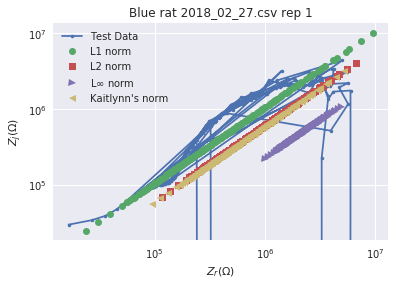

Optimization runtime 78.6180 seconds
Objective value: 662257.4383979007
Paramters: [5.77687110e-01 1.84621110e-02 9.03052984e+00 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 73.6721 seconds
Objective value: 2680103.065383202
Paramters: [4.26704222e+00 1.00000000e-04 9.75386025e+02 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 76.7077 seconds
Objective value: 19308890.717432234
Paramters: [3.4394071e+00 1.0000000e-04 1.0000000e+03 1.0000000e+03 1.0000000e-02] 

Optimization runtime 80.4321 seconds
Objective value: 1516957614890238.0
Paramters: [3.77646446e+00 1.00000000e-04 3.08697765e+02 1.00000000e+03
 1.00000000e-02] 



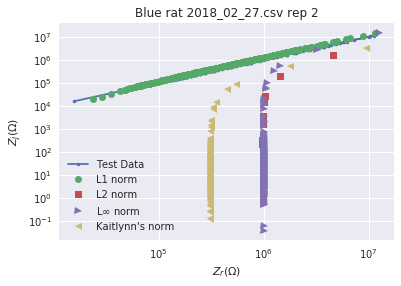

Optimization runtime 79.1520 seconds
Objective value: 1792067.7258292844
Paramters: [5.03052790e-01 5.30659275e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 73.0274 seconds
Objective value: 3141818.6574179707
Paramters: [4.44088776e-01 1.52971651e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 77.9263 seconds
Objective value: 31264428.21446843
Paramters: [1.76640151e+00 2.10394375e-03 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 80.5870 seconds
Objective value: 2115045379100691.0
Paramters: [3.58608412e-01 5.87759143e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 



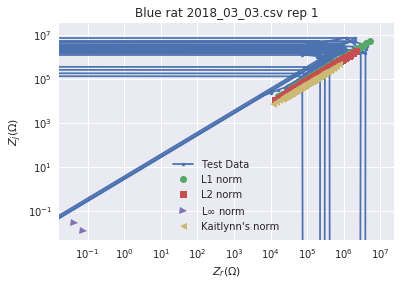

Optimization runtime 78.3748 seconds
Objective value: 1468490.8489419878
Paramters: [4.92319395e-01 5.94835144e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 72.8016 seconds
Objective value: 2779342.8266920475
Paramters: [4.22483846e-01 7.85590816e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 76.5413 seconds
Objective value: 21860566.917095844
Paramters: [6.95207095e-01 2.53808442e-02 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 

Optimization runtime 79.3951 seconds
Objective value: 1741574983586727.0
Paramters: [2.57042964e-01 5.08588501e-01 1.00000000e-04 1.00000000e-04
 1.00000000e+03] 



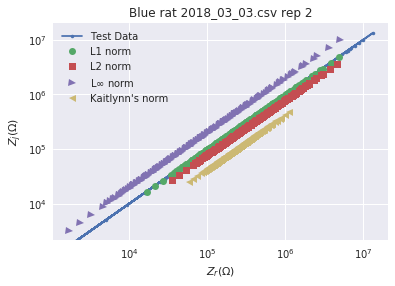

Optimization runtime 74.7559 seconds
Objective value: 55600.15581339455
Paramters: [5.60105354e-01 2.90752182e-02 4.20701868e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 69.5370 seconds
Objective value: 112972.43923244822
Paramters: [5.83387544e-01 2.38305590e-02 4.40601085e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 72.5300 seconds
Objective value: 1126131.6752266712
Paramters: [5.12963557e-01 3.11999384e-02 1.00000013e-04 1.00000000e-04
 9.99999458e+02] 

Optimization runtime 76.4878 seconds
Objective value: 144122822394.7087
Paramters: [5.41007903e-01 2.92393475e-02 1.16304332e+00 1.00000000e+03
 1.00000000e-02] 



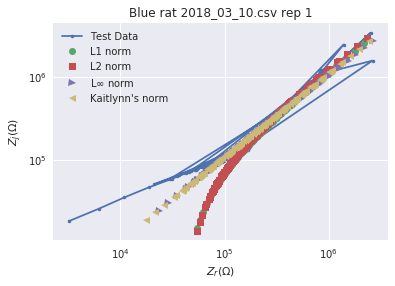

Optimization runtime 76.1512 seconds
Objective value: 64597.706870770315
Paramters: [4.99345677e-01 4.58458041e-02 1.17858976e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 69.1024 seconds
Objective value: 140861.62528395216
Paramters: [5.75149061e-01 2.57142036e-02 4.56921595e+01 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 72.3431 seconds
Objective value: 1405258.5352986052
Paramters: [7.26639709e-01 1.52761448e-02 1.00000000e+03 1.00000000e+03
 1.00000000e-02] 

Optimization runtime 75.9674 seconds
Objective value: 314219588053.3757
Paramters: [5.57775706e-01 2.84561496e-02 1.30010246e+00 1.00000000e+03
 1.00000000e-02] 



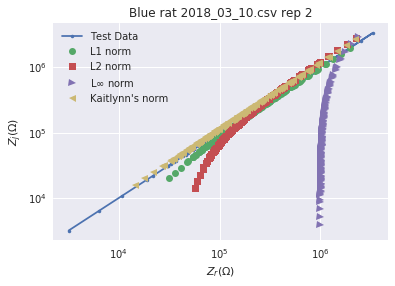

In [2]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[4, 0] = 1e-2
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_linf = np.zeros((10, 6))
res_lk = np.zeros((10, 6))

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        # # generate fake results
        # zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])
        # peform the optimizations
        _, _, x_l1, opt_l1 = opt_routine(otto_model_L1)
        _, _, x_l2, opt_l2 = opt_routine(otto_model_L2)
        _, _, x_linf, opt_linf = opt_routine(otto_model_L_inf)
        _, _, x_lk, opt_lk = opt_routine(otto_model_L2_Kait)
        plot_results(x_l1, x_l2, x_linf, x_lk,
                     'Blue rat ' + data + ' rep ' + str(i+1))

        # save the results into the array
        res_l1[ind, :5] = x_l1; res_l1[ind, 5] = opt_l1
        res_l2[ind, :5] = x_l2; res_l2[ind, 5] = opt_l2
        res_linf[ind, :5] = x_linf; res_linf[ind, 5] = opt_linf
        res_lk[ind, :5] = x_lk; res_lk[ind, 5] = opt_lk
